<a href="https://colab.research.google.com/github/satyam1289/XAI-CNN_Project_Tumor_Prediction/blob/main/XAI_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

folder_path = "/content/drive/MyDrive/archive"  # Replace with your actual path
print(os.listdir(folder_path))  # Lists all files and subfolders


['Training', 'Testing']


In [ ]:
!pip install shap lime scikit-image

import tensorflow as tf
import shap
import lime
import numpy as np
import matplotlib.pyplot as plt
import skimage
print("All libraries imported successfully!")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=c85835012f8c51638d2649e2049997df107bde8b4fcd7ec37ebf081b45cbb4ab
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
All libraries imported successfully!


In [ ]:
import os

base_path = "/content/drive/MyDrive/archive"

# Check main directory
print("Main Directory:", os.listdir(base_path))

# Check Training & Testing folders
train_path = os.path.join(base_path, "Training")
test_path = os.path.join(base_path, "Testing")

print("Training Categories:", os.listdir(train_path))
print("Testing Categories:", os.listdir(test_path))

Main Directory: ['Training', 'Testing']
Training Categories: ['notumor', 'glioma', 'pituitary', 'meningioma']
Testing Categories: ['pituitary', 'notumor', 'meningioma', 'glioma']


In [ ]:
for folder in os.listdir(train_path):
    folder_path = os.path.join(train_path, folder)
    print(f"{folder}: {len(os.listdir(folder_path))} images")

notumor: 100 images
glioma: 100 images
pituitary: 100 images
meningioma: 100 images


In [ ]:
for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    print(f"{folder}: {len(os.listdir(folder_path))} images")

pituitary: 100 images
notumor: 100 images
meningioma: 100 images
glioma: 100 images


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image size for CNN
img_size = (224, 224)
batch_size = 32

# Data augmentation & rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% validation split
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Load validation data
val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Load testing data
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 320 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 output classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 40  # Adjustable
history = model.fit(train_generator, validation_data=val_generator, epochs=epochs)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 86s 8s/step - accuracy: 0.1799 - loss: 1.4007 - val_accuracy: 0.3625 - val_loss: 1.2959
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 748ms/step - accuracy: 0.3279 - loss: 1.2854 - val_accuracy: 0.4000 - val_loss: 1.1955
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 572ms/step - accuracy: 0.4204 - loss: 1.2041 - val_accuracy: 0.4500 - val_loss: 1.1888
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 701ms/step - accuracy: 0.3689 - loss: 1.2140 - val_accuracy: 0.4250 - val_loss: 1.1138
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 573ms/step - accuracy: 0.4331 - loss: 1.1642 - val_accuracy: 0.3750 - val_loss: 1.1100
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 703ms/step - accuracy: 0.4096 - loss: 1.1555 - val_accuracy: 0.5125 - val_loss: 1.0735
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 564ms/step - accuracy: 0.4160 - loss: 1.0904 - val_accuracy: 0.4875 - val_loss: 1.0455
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 700ms/step - accuracy: 0.4932 - loss: 1.0921 - val_accuracy: 0.47

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

13/13 ━━━━━━━━━━━━━━━━━━━━ 95s 7s/step - accuracy: 0.5974 - loss: 2.8376
Test Accuracy: 60.00%


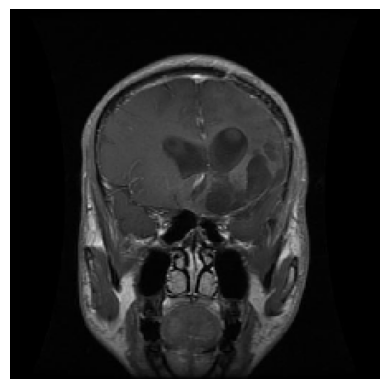

In [ ]:
import random
from tensorflow.keras.preprocessing import image

# Choose a class folder and image
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
test_image_path = "/content/drive/MyDrive/archive/Testing/glioma"  # Change class if needed
test_image_file = random.choice(os.listdir(test_image_path))

# Load image
img_path = os.path.join(test_image_path, test_image_file)
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.axis('off')
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━

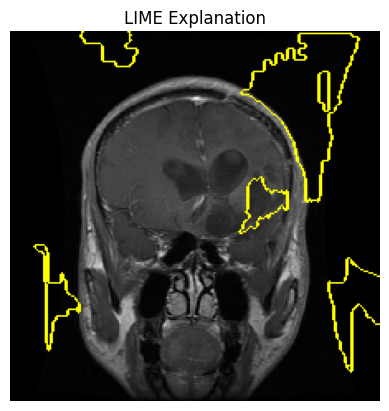

In [ ]:
import lime.lime_image
from skimage.segmentation import mark_boundaries

explainer = lime.lime_image.LimeImageExplainer()
img_array = np.expand_dims(image.img_to_array(img) / 255.0, axis=0)  # Normalize and reshape

explanation = explainer.explain_instance(
    img_array[0], model.predict, top_labels=1, hide_color=0, num_samples=1000
)

# Show the explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation")
plt.axis('off')
plt.show()


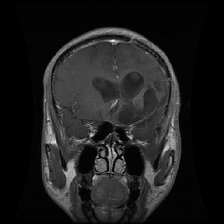

In [ ]:
img

In [ ]:
from tensorflow.keras.preprocessing import image
img_array

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]], dtype=float32)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


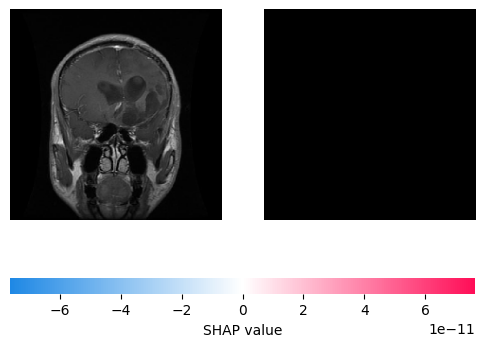

In [ ]:
# Create SHAP Explainer
background = np.random.rand(1, 224, 224, 3)  # A single random image as background

e = shap.GradientExplainer(model, background)


# Compute SHAP values
shap_values = e.shap_values(img_array)


# Visualize SHAP Explanations
shap.image_plot(shap_values, img_array)


In [ ]:
shap_values

array([[[[[ 2.52214164e-07,  1.88187581e-08, -6.51739583e-07,
            3.80706666e-07],
          [-4.98856082e-07, -1.45046073e-07,  7.98523274e-07,
           -1.54621645e-07],
          [-9.86177540e-08, -2.97151015e-08,  1.72964505e-07,
           -4.46315980e-08]],

         [[-8.47170725e-08, -3.06955847e-08,  1.58280614e-07,
           -4.28679279e-08],
          [-1.02711347e-07, -1.12549490e-08, -4.65811439e-07,
            5.79777634e-07],
          [-1.26960875e-09,  1.65028524e-09, -1.75818782e-09,
            1.37750622e-09]],

         [[-1.26866013e-07, -9.12916462e-08,  2.75143861e-07,
           -5.69862308e-08],
          [-1.16088167e-07, -1.30500851e-07,  1.18910043e-06,
           -9.42511633e-07],
          [-1.03863309e-08, -9.99942031e-08, -2.02198549e-07,
            3.12579402e-07]],

         ...,

         [[ 3.14882413e-08,  1.68257286e-09, -7.03921330e-07,
            6.70750353e-07],
          [-6.06043145e-08, -1.30455049e-07,  3.72768369e-07,
       